In [1]:
import h5py
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import numpy as np
import random
import scipy.io as sio
from scipy.signal import argrelmax
from scipy.spatial import distance_matrix
import sklearn.cluster as clus
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import warnings; warnings.simplefilter('ignore')

%matplotlib inline

In [2]:
# Read in the data from the labeled spectrum file
file_name = 'Labeled Data/8-27-18 A3D16F3 slide 2 brain 1.mat'
f = h5py.File(file_name, 'r')
data = {}
for k, v in f.items():
    data[k] = np.array(v)
print (f.items())

ItemsViewHDF5(<HDF5 file "8-27-18 A3D16F3 slide 2 brain 1.mat" (mode r)>)


In [3]:
# View the titles of the data sets included in the file
[(k,v) for k,v in f.items()]

[('#refs#', <HDF5 group "/#refs#" (31 members)>),
 ('ROI', <HDF5 dataset "ROI": shape (2, 5), type "|O">),
 ('ROIcount', <HDF5 dataset "ROIcount": shape (1, 1), type "<f8">),
 ('img', <HDF5 dataset "img": shape (69088, 140, 43), type "<f8">),
 ('imgX', <HDF5 dataset "imgX": shape (140, 1), type "<f8">),
 ('imgY', <HDF5 dataset "imgY": shape (43, 1), type "<f8">),
 ('imgZ', <HDF5 dataset "imgZ": shape (1, 69088), type "<f8">)]

Brain images at m/z value of 834.5411880484747


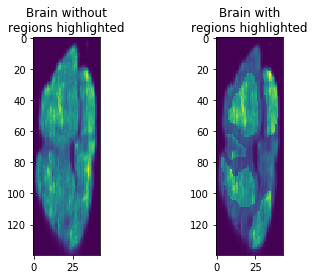

Pixel counts in regions:
left cortex: 328 pixels in region
right cortex: 283 pixels in region
middle: 152 pixels in region
left caudoputamen: 417 pixels in region
right caudoputamen: 532 pixels in region

Total pixels in image: 6020


In [4]:
# Get the regions from the labeled data file
region_count = int(data["ROIcount"])
regions = [np.array([x for x in f[data["ROI"][1,i]]]) for i in range(region_count)]

# Display the brain by displaying abundances at the m/z value that maximizes
# the abundance at a pixel within the body of the brain
pixel = (20,20)
brain_image = data['img'][np.argmax(data['img'][:,pixel[0],pixel[1]]),:,:]
print("Brain images at m/z value of",
        data["imgZ"][0][np.argmax(data['img'][:,pixel[0],pixel[1]])])
plt.subplot(121).imshow(brain_image)
plt.subplot(121).set_title("Brain without\nregions highlighted")
plt.subplot(122).imshow(brain_image + np.multiply(brain_image, sum(regions)))
plt.subplot(122).set_title("Brain with\nregions highlighted")
plt.show()

# Initialize containers for the region names and assigned colors
region_names = []
colors = ['k', 'r', 'y', 'g', 'b']

# Determine region names and amount of pixels in each region
print("Pixel counts in regions:")
for i in range(region_count):
    region_names.append(''.join([chr(x[0]) for x in f[data["ROI"][0,i]]]))
    print(region_names[-1], end=": ")
    print(sum(sum(regions[i])), "pixels in region")

# Output the total amount of pixels in the image
shape = data["img"].shape
print("\nTotal pixels in image:", shape[1]*shape[2])

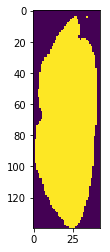

In [5]:
CUTOFF = 7300
plt.imshow(brain_image > CUTOFF)

In [6]:
xSize, ySize, zSize= data['img'].shape
n = 0
image_filter = (brain_image > CUTOFF)
region_pixel_counts = [0 for i in range(len(regions) + 1)]
region_averages = [np.zeros(xSize) for i in range(len(regions) + 1)]
overall_average = np.zeros(xSize)

for i in range(ySize):
    for j in range(zSize):
        if image_filter[i,j]:
            spectrum = data['img'][:,i,j]
            in_region = False
            for r in range(len(regions)):
                if regions[r][i,j] > 0:
                    in_region = True
                    region_pixel_counts[r] += 1
                    region_averages[r] += spectrum
                    break
            if not in_region:
                region_pixel_counts[-1] += 1
                region_averages[-1] += spectrum
            overall_average += spectrum
        
        if n % 100 == 0:
            print("Finished reading", n, "out of", ySize*zSize, "pixels", end="\r")

        n += 1

for r in range(len(regions) + 1):
    region_averages[r] /= region_pixel_counts[r]
overall_average /= sum(region_pixel_counts)
        
region_pixel_counts

[328, 283, 152, 417, 532, 2263]

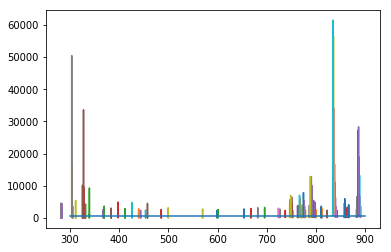

In [7]:
census_maxima = set([])
imgZ = data["imgZ"][0]
region_names.append("brain other")
MINIMUM_INTENSITY = 500
MAXIMUM_PEAK_COUNT = 500
DISPLAY_PEAK_COUNT = 100

spectrum = overall_average
assert len(spectrum) == xSize
maxima = argrelmax(spectrum)[0]
maxima = maxima[spectrum[maxima] > MINIMUM_INTENSITY]
sort = np.argsort(spectrum[maxima])
for s in maxima[sort[-DISPLAY_PEAK_COUNT:]]:
    indices = list(range(s-20, s+20))
    plt.plot([imgZ[i] for i in indices],
            [spectrum[i] for i in indices])
plt.plot(np.linspace(300, 900, 1000),
        [spectrum[maxima[sort[-MAXIMUM_PEAK_COUNT - 1]]]
        for i in range(1000)])
plt.show()
sort = sort[-MAXIMUM_PEAK_COUNT:]
maxima = maxima[sort]
census_maxima = census_maxima.union(set(maxima))

In [8]:
print(len(census_maxima))
maxima_list = np.array(sorted(census_maxima))

500


In [9]:
maxima_values = np.array([imgZ[m] for m in maxima_list])
labels = np.array([None]*n)
numbered_labels = np.array([-1]*n)

In [10]:
spectra = np.zeros((n, len(maxima_list)))
s = 0

for i in range(ySize):
    for j in range(zSize):
        spectra[s] = data['img'][:,i,j][maxima_list]
        labeled = False
        for r in range(region_count):
            if regions[r][i,j] == 1:
                labels[s] = region_names[r]
                numbered_labels[s] = r
                labeled = True
        if not labeled:
            labels[s] = ("brain other" if brain_image[i,j] > 7300 else "not brain")
            numbered_labels[s] = (5 if brain_image[i,j] > 7300 else 6)
        
        if s % 100 == 0:
            print("Finished reading", s, "out of", ySize*zSize, "rows", end="\r")
            
        s += 1

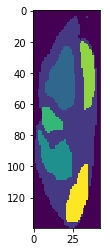

In [11]:
plt.imshow(6 - numbered_labels.reshape(ySize, zSize))

In [12]:
imgZ[maxima_list[181]] # 71, 257, 181

599.5002165450752

In [13]:
selection = spectra[numbered_labels != 6]
selection = np.std(selection, axis=0)
spectra_filter = selection > 5000

In [14]:
spectra = spectra[:,spectra_filter]
spectra.shape

(6020, 12)

In [15]:
X = spectra[labels != "not brain"]
clustering = clus.AffinityPropagation().fit(X)

Number of labels: 96
3975


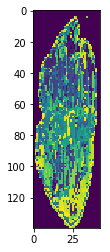

In [16]:
labels_ = clustering.labels_
print("Number of labels:", len(set(labels_)))
labels_ += 1
results = np.zeros((ySize, zSize))
index = 0
for i in range(ySize):
    for j in range(zSize):
        if image_filter[i,j]:
            results[i,j] = labels_[index]
            index += 1
print(index)
plt.imshow(results)

In [17]:
X = spectra[labels != "not brain"]
clustering = clus.SpectralClustering().fit(X)

Number of labels: 8
3975


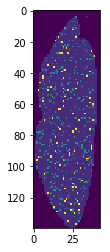

In [18]:
labels_ = clustering.labels_
print("Number of labels:", len(set(labels_)))
labels_ += 1
results = np.zeros((ySize, zSize))
index = 0
for i in range(ySize):
    for j in range(zSize):
        if image_filter[i,j]:
            results[i,j] = labels_[index]
            index += 1
print(index)
plt.imshow(results)

In [19]:
X = spectra[labels != "not brain"]
clustering = clus.AgglomerativeClustering().fit(X)

Number of labels: 2
3975


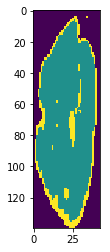

In [20]:
labels_ = clustering.labels_
print("Number of labels:", len(set(labels_)))
labels_ += 1
results = np.zeros((ySize, zSize))
index = 0
for i in range(ySize):
    for j in range(zSize):
        if image_filter[i,j]:
            results[i,j] = labels_[index]
            index += 1
print(index)
plt.imshow(results)

In [21]:
X = spectra[labels != "not brain"]
clustering = clus.DBSCAN().fit(X)

Number of labels: 1
3975


array([0, 0, 0, ..., 0, 0, 0])

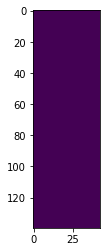

In [22]:
labels_ = clustering.labels_
print("Number of labels:", len(set(labels_)))
labels_ += 1
results = np.zeros((ySize, zSize))
index = 0
for i in range(ySize):
    for j in range(zSize):
        if image_filter[i,j]:
            results[i,j] = labels_[index]
            index += 1
print(index)
plt.imshow(results)
labels_

In [23]:
X = spectra[labels != "not brain"]
clustering = clus.Birch().fit(X)

Number of labels: 3
3975


array([2, 2, 2, ..., 2, 2, 2])

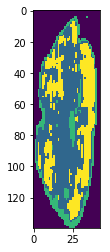

In [24]:
labels_ = clustering.labels_
print("Number of labels:", len(set(labels_)))
labels_ += 1
results = np.zeros((ySize, zSize))
index = 0
for i in range(ySize):
    for j in range(zSize):
        if image_filter[i,j]:
            results[i,j] = labels_[index]
            index += 1
print(index)
plt.imshow(results)
labels_

In [25]:
X = spectra[labels != "not brain"]
clustering = clus.MeanShift().fit(X)

labels_ = clustering.labels_
print("Number of labels:", len(set(labels_)))
labels_ += 1
results = np.zeros((ySize, zSize))
index = 0
for i in range(ySize):
    for j in range(zSize):
        if image_filter[i,j]:
            results[i,j] = labels_[index]
            index += 1
print(index)
plt.imshow(results)
labels_